In [1]:
%matplotlib ipympl
import json
import time
from datetime import datetime
from functools import partial

import allantools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.signal import welch

from onix.data_tools import get_experiment_data, get_analysis_file_path
from onix.analysis.fitter import Fitter

In [2]:
def gaussian(f, f0, sigma, a, c):
    return a * np.exp(-(f-f0)**2 / (2 * sigma**2)) + c

def gaussian_fitter_histogram(xs, hists):
    xs = xs[1:] - (xs[1] - xs[0]) / 2
    nonzero_hist_mask = hists != 0
    fitter = Fitter(gaussian)
    fitter.set_nicknames({"f0": "$f_0$", "sigma": "$\\sigma$", "a": "$a$", "c": "$c$"})
    fitter.set_units({"f0": "Hz", "sigma": "Hz"})
    fitter.set_data(xs[nonzero_hist_mask], hists[nonzero_hist_mask], np.sqrt(hists[nonzero_hist_mask]))
    fitter.set_p0({"f0": np.average(xs, weights=hists), "sigma": np.std(xs), "a": np.max(hists) - np.min(hists), "c": np.min(hists)})
    return fitter

In [346]:
analysis_number = 611 # 607
file_name = "all_data.json"
file_path = get_analysis_file_path(analysis_number, file_name)
with open(file_path) as f:
    all_results = np.array(json.load(f))

In [347]:
def convert_to_timestamp(input):
    ret = datetime.strptime(input.decode("utf-8"), "%Y-%m-%d %H:%M:%S.%f+00:00").timestamp()
    return ret

# unlock_data = np.loadtxt(
#     "/home/icarus/Documents/data/manual/2024_07/02/unlock_counter.csv",  # the data is actually in EDT although labeled GMT
#     delimiter=",",
#     skiprows=1,
#     converters={
#         0: convert_to_timestamp,
#     },
# )
# unlock_data_times = np.transpose(unlock_data)[0] - 3600 * 4
# unlock_times = []
# unlock_data_counters = np.transpose(unlock_data)[1]
# for kk, value in enumerate(unlock_data_counters[1:] - unlock_data_counters[:-1]):
#     if value > 0:
#         unlock_times.append((unlock_data_times[kk] + unlock_data_times[kk+1]) / 2)

In [348]:
all_mask = np.ones(len(all_results), dtype=bool)
unlock_mask = np.ones(len(all_results), dtype=bool)
D_p1_mask = np.ones(len(all_results), dtype=bool)
D_m1_mask = np.ones(len(all_results), dtype=bool)
E_p1_mask = np.ones(len(all_results), dtype=bool)
E_m1_mask = np.ones(len(all_results), dtype=bool)
a_mask = np.ones(len(all_results), dtype=bool)
b_mask = np.ones(len(all_results), dtype=bool)
for kk, value in enumerate(all_results):
    # for unlock_time in unlock_times:
    #     if value["epoch_times"][0] - 2 < unlock_time and unlock_time < value["epoch_times"][1]:
    #         unlock_mask[kk] = False
    #         break
    if value["freq_center"] > 200000:
        b_mask[kk] = False
    else:
        a_mask[kk] = False
    if value["D"]:
        D_p1_mask[kk] = True
        D_m1_mask[kk] = False
    else:
        D_p1_mask[kk] = False
        D_m1_mask[kk] = True
    if value["E"]:
        E_p1_mask[kk] = True
        E_m1_mask[kk] = False
    else:
        E_p1_mask[kk] = False
        E_m1_mask[kk] = True
        
print(f"Laser unlocked data is {(len(all_results) - len(all_results[unlock_mask])) / len(all_results) * 100:.1f}%.")

start_mask = np.ones(len(all_results), dtype=bool)
for kk in range(0):
    start_mask[kk] = False

Laser unlocked data is 0.0%.


## General time-series plots

ZeroDivisionError: Weights sum to zero, can't be normalized

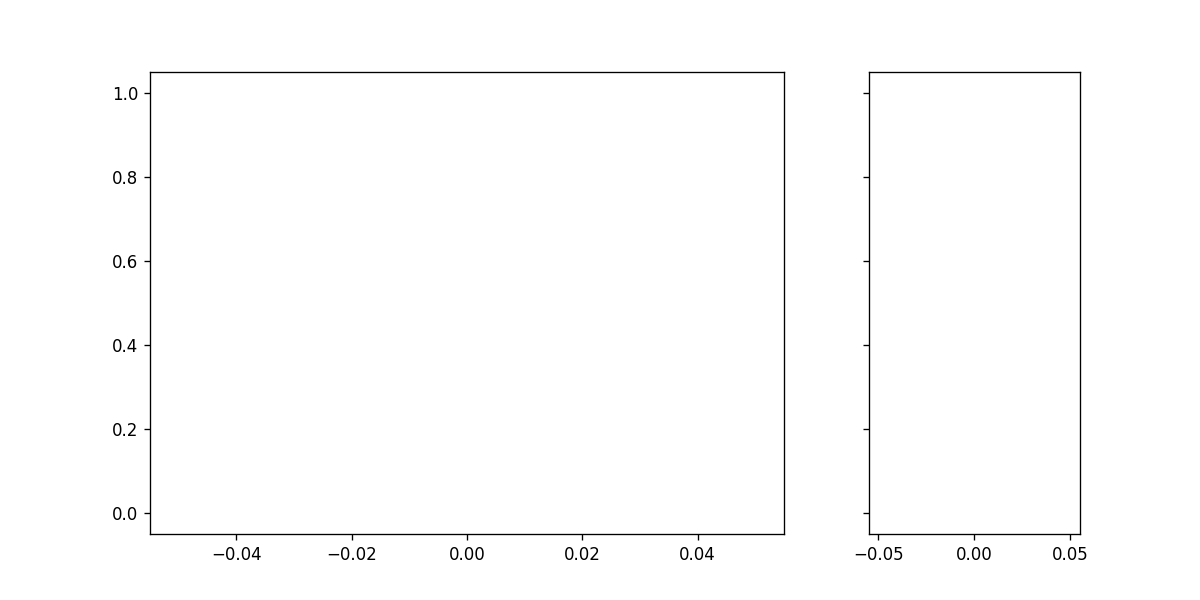

In [349]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1]})
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

mask = unlock_mask & start_mask & a_mask
fs = np.array([result["freq_center"] for result in all_results[mask]])
ts = np.array([result["epoch_times"][0] for result in all_results[mask]])

axs[0].plot(ts, fs, alpha=bins_alpha)
axs[1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)

hists, xs = np.histogram(fs, bins=n_bins)
fitter = gaussian_fitter_histogram(xs, hists)
fitter.fit()
label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
axs[1].plot(fitter.fitted_value(xs), xs, color=f"C0", label=label)
    
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("$a\\bar{a}$ frequency (Hz)")
axs[1].set_xlabel("Occurrences")
axs[1].legend()
plt.tight_layout()
plt.show()

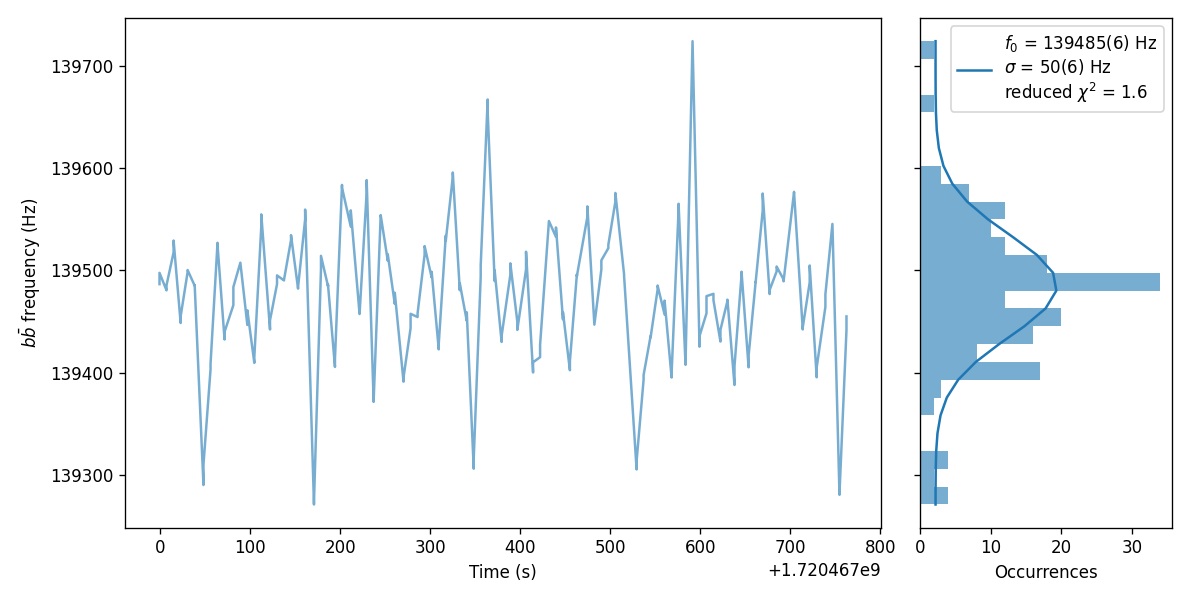

In [350]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1]})
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

mask = unlock_mask & start_mask & b_mask
fs = np.array([result["freq_center"] for result in all_results[mask]])
ts = np.array([result["epoch_times"][0] for result in all_results[mask]])

axs[0].plot(ts, fs, alpha=bins_alpha)
axs[1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)

hists, xs = np.histogram(fs, bins=n_bins)
fitter = gaussian_fitter_histogram(xs, hists)
fitter.fit()
label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
axs[1].plot(fitter.fitted_value(xs), xs, color=f"C0", label=label)
    
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("$b\\bar{b}$ frequency (Hz)")
axs[1].set_xlabel("Occurrences")
axs[1].legend()
plt.tight_layout()
plt.show()

ZeroDivisionError: Weights sum to zero, can't be normalized

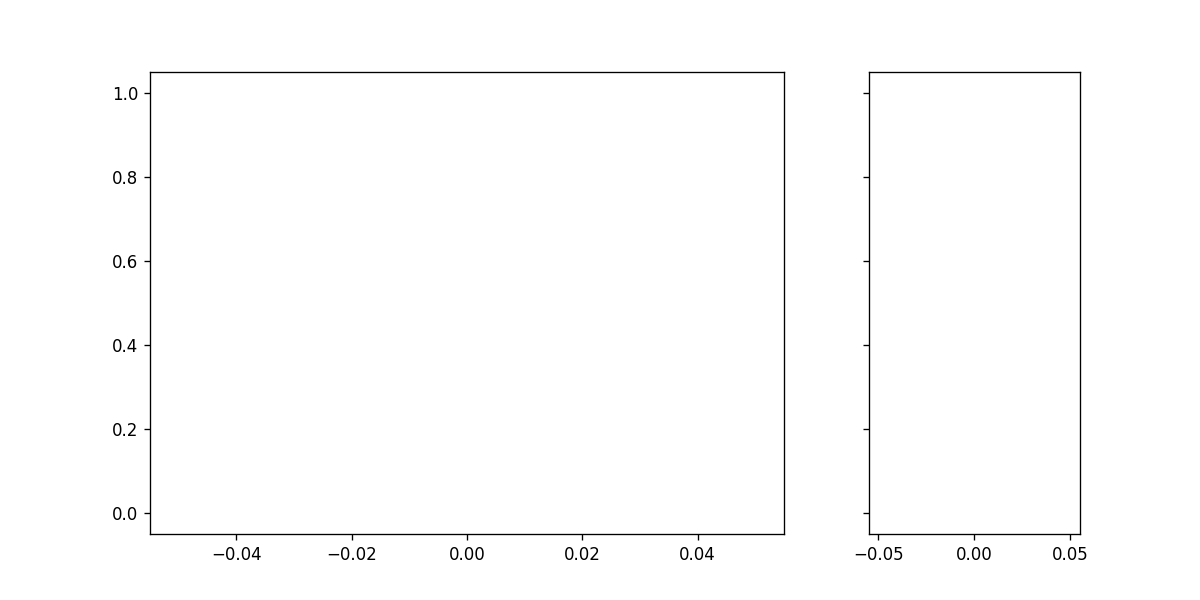

In [351]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1]})
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

for kk, D_mask in enumerate([D_p1_mask, D_m1_mask]):
    mask = unlock_mask & start_mask & a_mask & D_mask
    fs = np.array([result["freq_center"] for result in all_results[mask]])
    ts = np.array([result["epoch_times"][0] for result in all_results[mask]])

    if kk == 0:
        label = "$\\vec{D} = +1$"
    else:
        label = "$\\vec{D} = -1$"
    axs[0].plot(ts, fs, label=label, alpha=bins_alpha)
    axs[1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)
    
    hists, xs = np.histogram(fs, bins=n_bins)
    fitter = gaussian_fitter_histogram(xs, hists)
    fitter.fit()
    label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
    axs[1].plot(fitter.fitted_value(xs), xs, color=f"C{kk}", label=label)
    
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("$a\\bar{a}$ frequency (Hz)")
axs[0].legend()
axs[1].set_xlabel("Occurrences")
axs[1].legend()
plt.tight_layout()
plt.show()

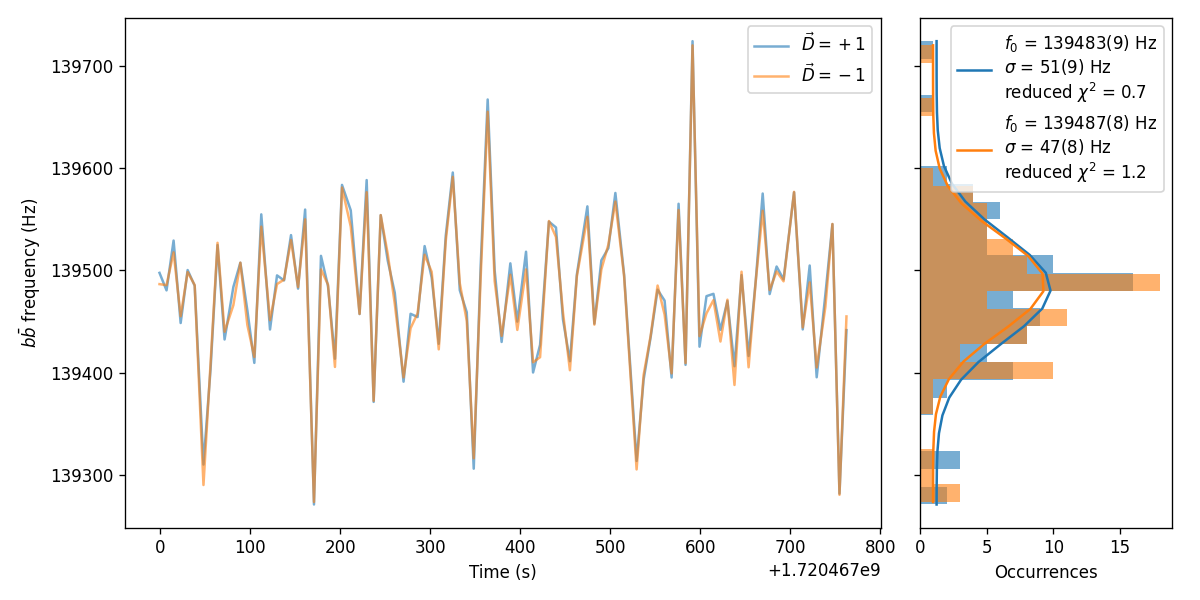

In [352]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1]})
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

for kk, D_mask in enumerate([D_p1_mask, D_m1_mask]):
    mask = unlock_mask & start_mask & b_mask & D_mask
    fs = np.array([result["freq_center"] for result in all_results[mask]])
    ts = np.array([result["epoch_times"][0] for result in all_results[mask]])

    if kk == 0:
        label = "$\\vec{D} = +1$"
    else:
        label = "$\\vec{D} = -1$"
    axs[0].plot(ts, fs, label=label, alpha=bins_alpha)
    axs[1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)
    
    hists, xs = np.histogram(fs, bins=n_bins)
    fitter = gaussian_fitter_histogram(xs, hists)
    fitter.fit()
    label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
    axs[1].plot(fitter.fitted_value(xs), xs, color=f"C{kk}", label=label)
    
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("$b\\bar{b}$ frequency (Hz)")
axs[0].legend()
axs[1].set_xlabel("Occurrences")
axs[1].legend()
plt.tight_layout()
plt.show()

ZeroDivisionError: Weights sum to zero, can't be normalized

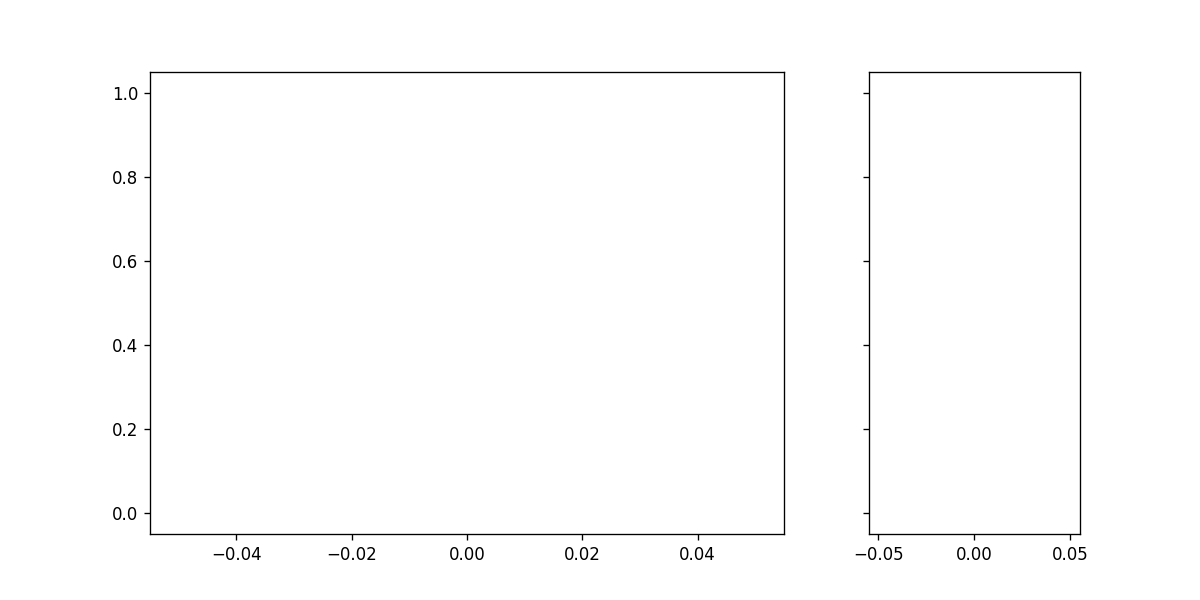

In [337]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1]})
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

mask1 = unlock_mask & start_mask & a_mask & D_p1_mask
mask2 = unlock_mask & start_mask & a_mask & D_m1_mask
fs = np.array([result["freq_center"] for result in all_results[mask1]]) - np.array([result["freq_center"] for result in all_results[mask2]])
ts = np.array([result["epoch_times"][0] for result in all_results[mask1]])

label = "$\\vec{D} = +1 - \\vec{D} = -1$"
axs[0].plot(ts, fs, label=label, alpha=bins_alpha)
axs[1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)

hists, xs = np.histogram(fs, bins=n_bins)
fitter = gaussian_fitter_histogram(xs, hists)
fitter.fit()
label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
axs[1].plot(fitter.fitted_value(xs), xs, color=f"C0", label=label)
    
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("$a\\bar{a}$ frequency offset (Hz)")
axs[0].legend()
axs[1].set_xlabel("Occurrences")
axs[1].legend()
plt.tight_layout()
plt.show()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

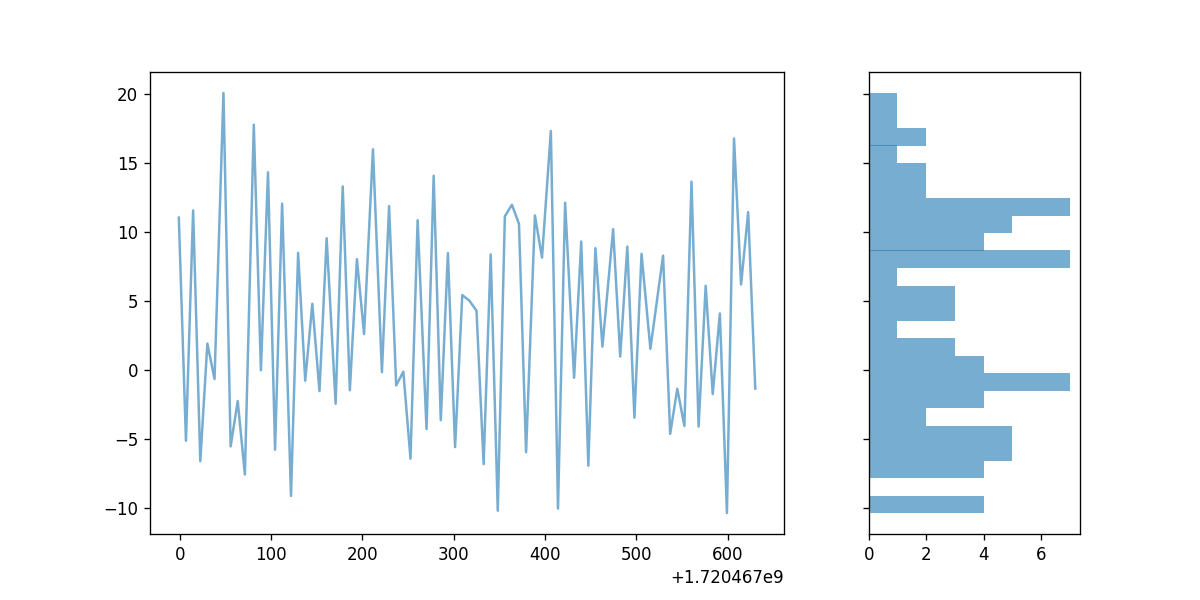

In [338]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1]})
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

mask1 = unlock_mask & start_mask & b_mask & D_p1_mask
mask2 = unlock_mask & start_mask & b_mask & D_m1_mask
fs = np.array([result["freq_center"] for result in all_results[mask1]]) - np.array([result["freq_center"] for result in all_results[mask2]])
ts = np.array([result["epoch_times"][0] for result in all_results[mask1]])

label = "$\\vec{D} = +1 - \\vec{D} = -1$"
axs[0].plot(ts, fs, label=label, alpha=bins_alpha)
axs[1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)

hists, xs = np.histogram(fs, bins=n_bins)
fitter = gaussian_fitter_histogram(xs, hists)
fitter.fit()
label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
axs[1].plot(fitter.fitted_value(xs), xs, color=f"C0", label=label)
    
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("$b\\bar{b}$ frequency offset (Hz)")
axs[0].legend()
axs[1].set_xlabel("Occurrences")
axs[1].legend()
plt.tight_layout()
plt.show()

ZeroDivisionError: Weights sum to zero, can't be normalized

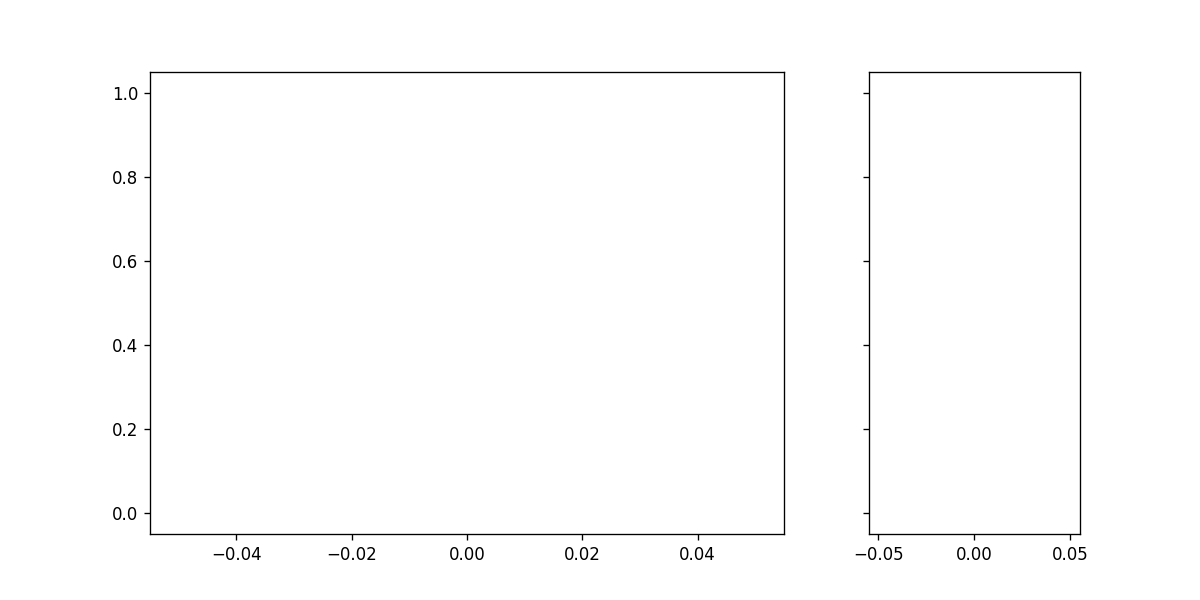

In [311]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1]})
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

for kk, E_mask in enumerate([E_p1_mask, E_m1_mask]):
    mask = unlock_mask & start_mask & a_mask & E_mask
    fs = np.array([result["freq_center"] for result in all_results[mask]])
    ts = np.array([result["epoch_times"][0] for result in all_results[mask]])

    if kk == 0:
        label = "$\\vec{E} = +1$"
    else:
        label = "$\\vec{E} = -1$"
    axs[0].plot(ts, fs, label=label, alpha=bins_alpha)
    axs[1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)
    
    hists, xs = np.histogram(fs, bins=n_bins)
    fitter = gaussian_fitter_histogram(xs, hists)
    fitter.fit()
    label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
    axs[1].plot(fitter.fitted_value(xs), xs, color=f"C{kk}", label=label)
    
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("$a\\bar{a}$ frequency (Hz)")
axs[0].legend()
axs[1].set_xlabel("Occurrences")
axs[1].legend()
plt.tight_layout()
plt.show()

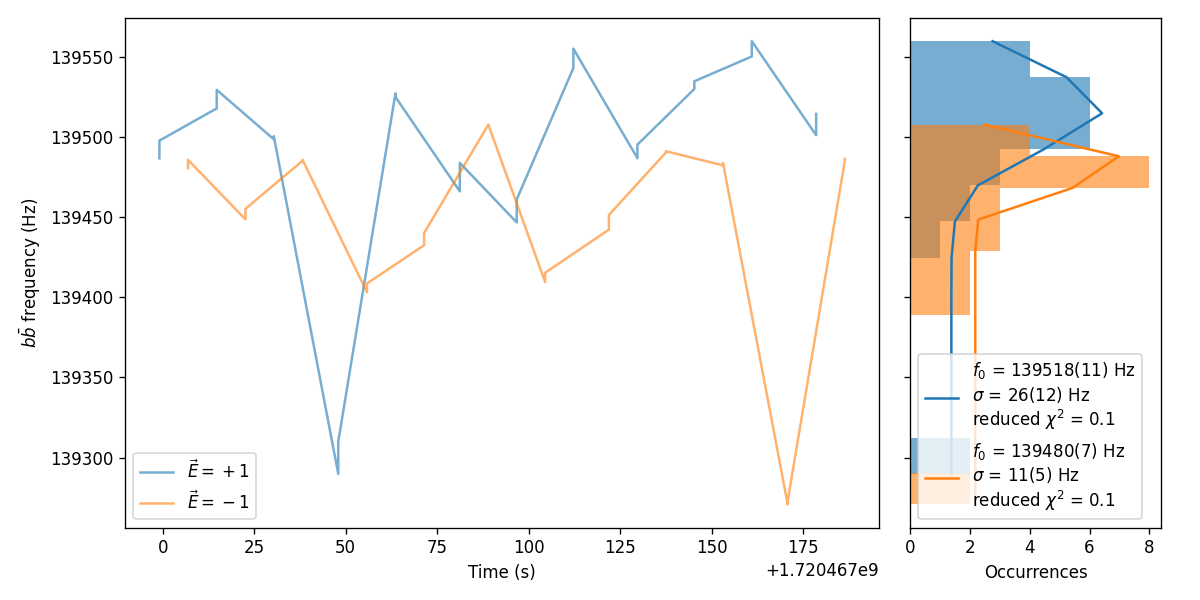

In [312]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1]})
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

for kk, E_mask in enumerate([E_p1_mask, E_m1_mask]):
    mask = unlock_mask & start_mask & b_mask & E_mask
    fs = np.array([result["freq_center"] for result in all_results[mask]])
    ts = np.array([result["epoch_times"][0] for result in all_results[mask]])

    if kk == 0:
        label = "$\\vec{E} = +1$"
    else:
        label = "$\\vec{E} = -1$"
    axs[0].plot(ts, fs, label=label, alpha=bins_alpha)
    axs[1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)
    
    hists, xs = np.histogram(fs, bins=n_bins)
    fitter = gaussian_fitter_histogram(xs, hists)
    fitter.fit()
    label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
    axs[1].plot(fitter.fitted_value(xs), xs, color=f"C{kk}", label=label)
    
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("$b\\bar{b}$ frequency (Hz)")
axs[0].legend()
axs[1].set_xlabel("Occurrences")
axs[1].legend()
plt.tight_layout()
plt.show()

ZeroDivisionError: Weights sum to zero, can't be normalized

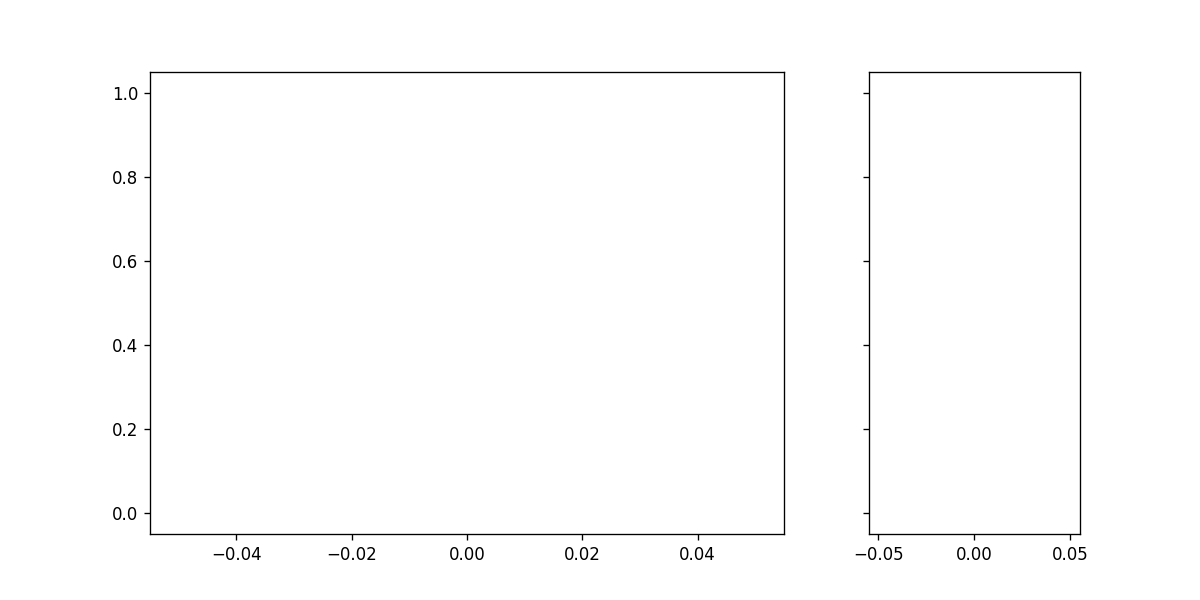

In [313]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1]})
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

for kk, E_mask in enumerate([E_p1_mask, E_m1_mask]):
    mask = unlock_mask & start_mask & a_mask * D_p1_mask & E_mask
    fs = np.array([result["freq_center"] for result in all_results[mask]])
    ts = np.array([result["epoch_times"][0] for result in all_results[mask]])

    if kk == 0:
        label = "$\\vec{D} = +1, \\vec{E} = +1$"
    else:
        label = "$\\vec{D} = +1, \\vec{E} = -1$"
    axs[0].plot(ts, fs, label=label, alpha=bins_alpha)
    axs[1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)
    
    hists, xs = np.histogram(fs, bins=n_bins)
    fitter = gaussian_fitter_histogram(xs, hists)
    fitter.fit()
    label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
    axs[1].plot(fitter.fitted_value(xs), xs, color=f"C{kk}", label=label)
    
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("$a\\bar{a}$ frequency (Hz)")
axs[0].legend()
axs[1].set_xlabel("Occurrences")
axs[1].legend()
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1]})
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

for kk, E_mask in enumerate([E_p1_mask, E_m1_mask]):
    mask = unlock_mask & start_mask & a_mask * D_m1_mask & E_mask
    fs = np.array([result["freq_center"] for result in all_results[mask]])
    ts = np.array([result["epoch_times"][0] for result in all_results[mask]])

    if kk == 0:
        label = "$\\vec{D} = -1, \\vec{E} = +1$"
    else:
        label = "$\\vec{D} = -1, \\vec{E} = -1$"
    axs[0].plot(ts, fs, label=label, alpha=bins_alpha)
    axs[1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)
    
    hists, xs = np.histogram(fs, bins=n_bins)
    fitter = gaussian_fitter_histogram(xs, hists)
    fitter.fit()
    label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
    axs[1].plot(fitter.fitted_value(xs), xs, color=f"C{kk}", label=label)
    
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("$a\\bar{a}$ frequency (Hz)")
axs[0].legend()
axs[1].set_xlabel("Occurrences")
axs[1].legend()
plt.tight_layout()
plt.show()

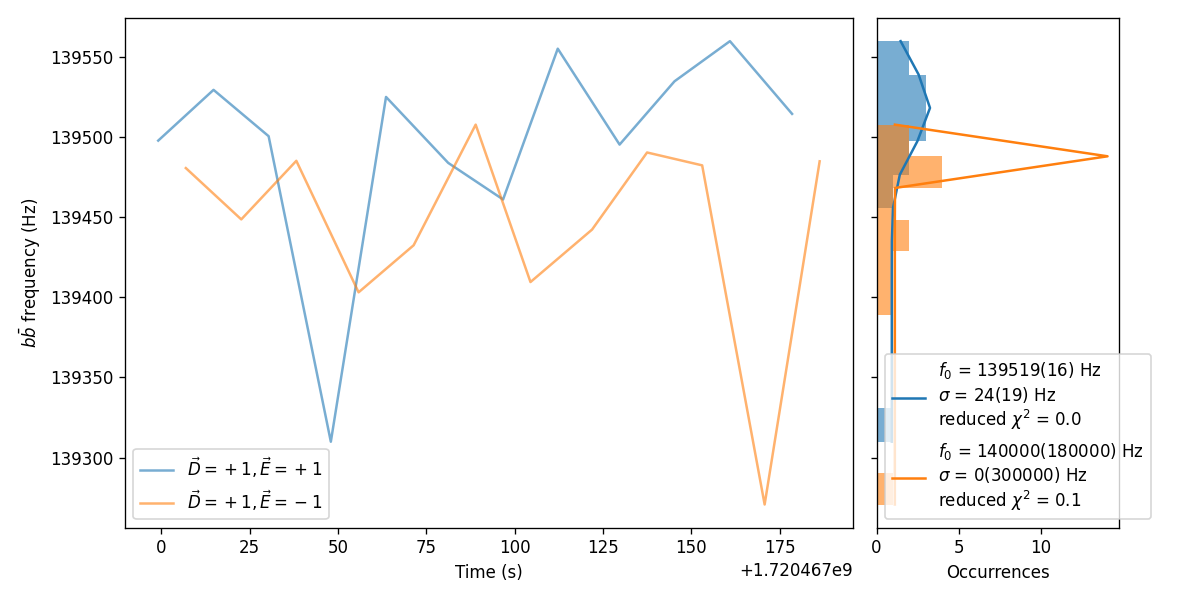

In [314]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1]})
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

for kk, E_mask in enumerate([E_p1_mask, E_m1_mask]):
    mask = unlock_mask & start_mask & b_mask * D_p1_mask & E_mask
    fs = np.array([result["freq_center"] for result in all_results[mask]])
    ts = np.array([result["epoch_times"][0] for result in all_results[mask]])

    if kk == 0:
        label = "$\\vec{D} = +1, \\vec{E} = +1$"
    else:
        label = "$\\vec{D} = +1, \\vec{E} = -1$"
    axs[0].plot(ts, fs, label=label, alpha=bins_alpha)
    axs[1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)
    
    hists, xs = np.histogram(fs, bins=n_bins)
    fitter = gaussian_fitter_histogram(xs, hists)
    fitter.fit()
    label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
    axs[1].plot(fitter.fitted_value(xs), xs, color=f"C{kk}", label=label)
    
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("$b\\bar{b}$ frequency (Hz)")
axs[0].legend()
axs[1].set_xlabel("Occurrences")
axs[1].legend()
plt.tight_layout()
plt.show()

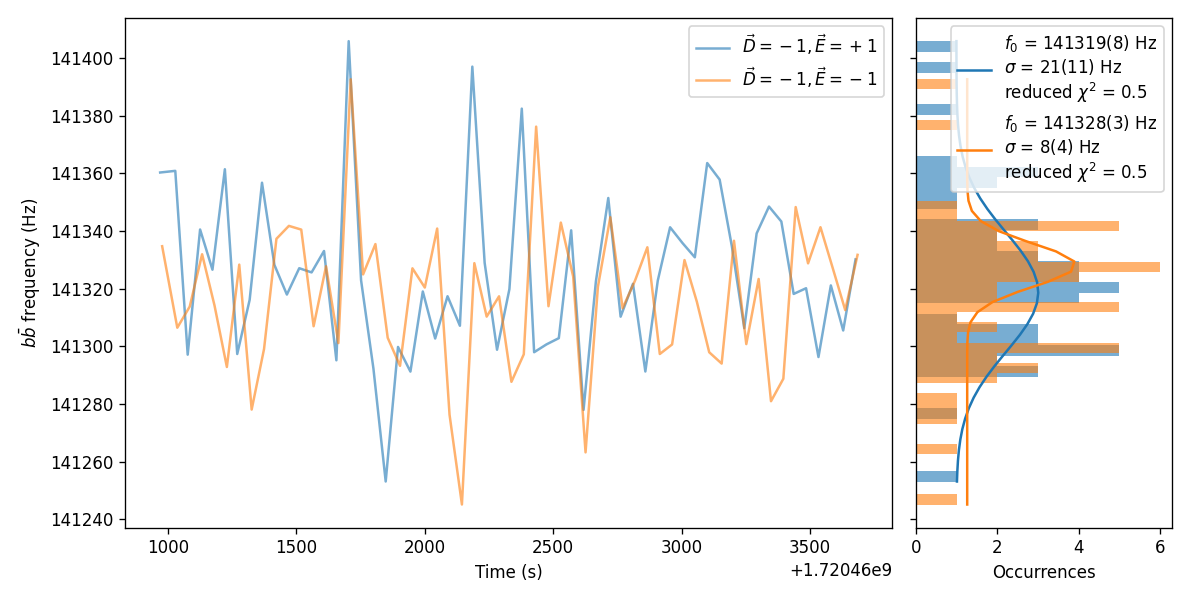

In [265]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1]})
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

for kk, E_mask in enumerate([E_p1_mask, E_m1_mask]):
    mask = unlock_mask & start_mask & b_mask * D_m1_mask & E_mask
    fs = np.array([result["freq_center"] for result in all_results[mask]])
    ts = np.array([result["epoch_times"][0] for result in all_results[mask]])

    if kk == 0:
        label = "$\\vec{D} = -1, \\vec{E} = +1$"
    else:
        label = "$\\vec{D} = -1, \\vec{E} = -1$"
    axs[0].plot(ts, fs, label=label, alpha=bins_alpha)
    axs[1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)
    
    hists, xs = np.histogram(fs, bins=n_bins)
    fitter = gaussian_fitter_histogram(xs, hists)
    fitter.fit()
    label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
    axs[1].plot(fitter.fitted_value(xs), xs, color=f"C{kk}", label=label)
    
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("$b\\bar{b}$ frequency (Hz)")
axs[0].legend()
axs[1].set_xlabel("Occurrences")
axs[1].legend()
plt.tight_layout()
plt.show()

## Frequency-domain analysis

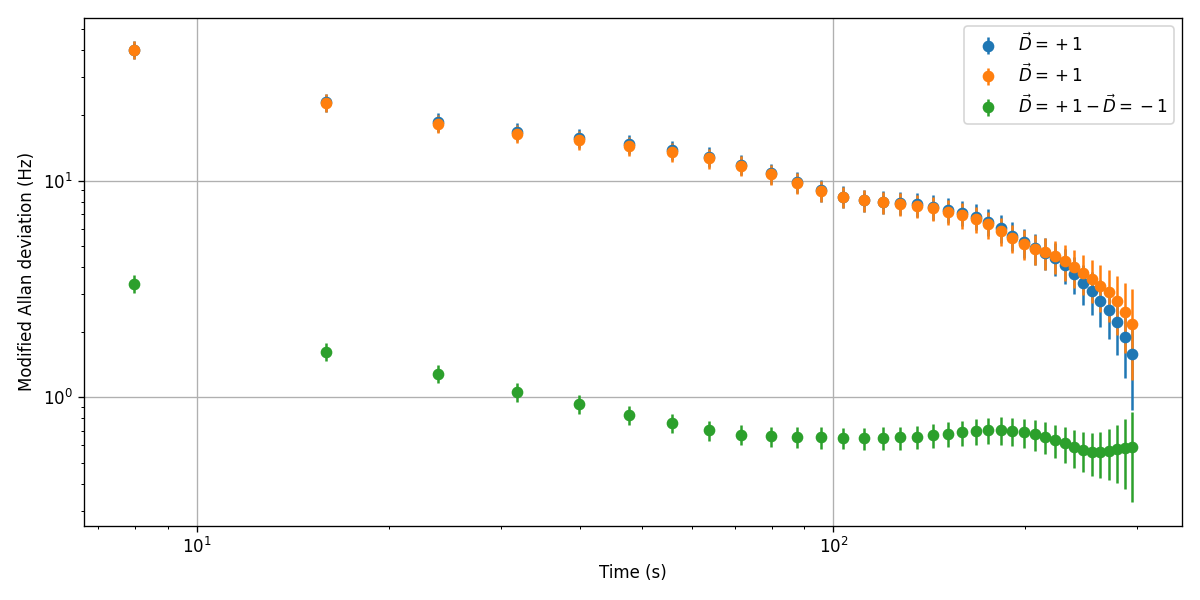

In [266]:
mask1 = unlock_mask & start_mask & a_mask & D_p1_mask
mask2 = unlock_mask & start_mask & a_mask & D_m1_mask

fs1 = np.array([result["freq_center"] for result in all_results[mask1]])
taus1 = np.logspace(0, np.log10(len(fs1) // 3), 200)
real_taus1, allan1, allan_err1, _ = allantools.mdev(fs1, data_type="freq", taus=taus1)
real_taus1 *= all_results[mask1][1]["epoch_times"][0] - all_results[mask1][0]["epoch_times"][0]

fs2 = np.array([result["freq_center"] for result in all_results[mask2]])
taus2 = np.logspace(0, np.log10(len(fs2) // 3), 200)
real_taus2, allan2, allan_err2, _ = allantools.mdev(fs2, data_type="freq", taus=taus2)
real_taus2 *= all_results[mask2][1]["epoch_times"][0] - all_results[mask2][0]["epoch_times"][0]

fs3 = fs2 - fs1
taus3 = np.logspace(0, np.log10(len(fs3) // 3), 200)
real_taus3, allan3, allan_err3, _ = allantools.mdev(fs3, data_type="freq", taus=taus3)
real_taus3 *= all_results[mask1][1]["epoch_times"][0] - all_results[mask1][0]["epoch_times"][0]

fig, ax = plt.subplots(figsize = (10, 5), dpi = 120)
ax.errorbar(real_taus1, allan1, allan_err1, fmt="o", label="$\\vec{D}=+1$")
ax.errorbar(real_taus2, allan2, allan_err2, fmt="o", label="$\\vec{D}=+1$")
ax.errorbar(real_taus3, allan3, allan_err3, fmt="o", label="$\\vec{D}=+1 - \\vec{D}=-1$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Modified Allan deviation (Hz)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

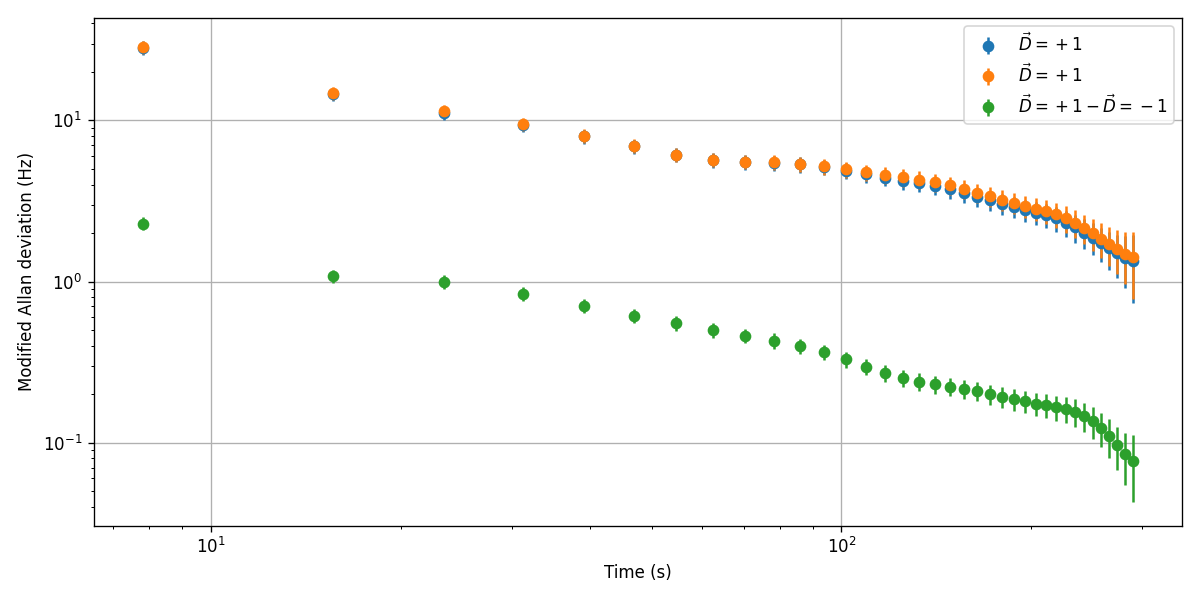

In [267]:
mask1 = unlock_mask & start_mask & b_mask & D_p1_mask
mask2 = unlock_mask & start_mask & b_mask & D_m1_mask

fs1 = np.array([result["freq_center"] for result in all_results[mask1]])
taus1 = np.logspace(0, np.log10(len(fs1) // 3), 200)
real_taus1, allan1, allan_err1, _ = allantools.mdev(fs1, data_type="freq", taus=taus1)
real_taus1 *= all_results[mask1][1]["epoch_times"][0] - all_results[mask1][0]["epoch_times"][0]

fs2 = np.array([result["freq_center"] for result in all_results[mask2]])
taus2 = np.logspace(0, np.log10(len(fs2) // 3), 200)
real_taus2, allan2, allan_err2, _ = allantools.mdev(fs2, data_type="freq", taus=taus2)
real_taus2 *= all_results[mask2][1]["epoch_times"][0] - all_results[mask2][0]["epoch_times"][0]

fs3 = fs2 - fs1
taus3 = np.logspace(0, np.log10(len(fs3) // 3), 200)
real_taus3, allan3, allan_err3, _ = allantools.mdev(fs3, data_type="freq", taus=taus3)
real_taus3 *= all_results[mask1][1]["epoch_times"][0] - all_results[mask1][0]["epoch_times"][0]

fig, ax = plt.subplots(figsize = (10, 5), dpi = 120)
ax.errorbar(real_taus1, allan1, allan_err1, fmt="o", label="$\\vec{D}=+1$")
ax.errorbar(real_taus2, allan2, allan_err2, fmt="o", label="$\\vec{D}=+1$")
ax.errorbar(real_taus3, allan3, allan_err3, fmt="o", label="$\\vec{D}=+1 - \\vec{D}=-1$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Modified Allan deviation (Hz)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

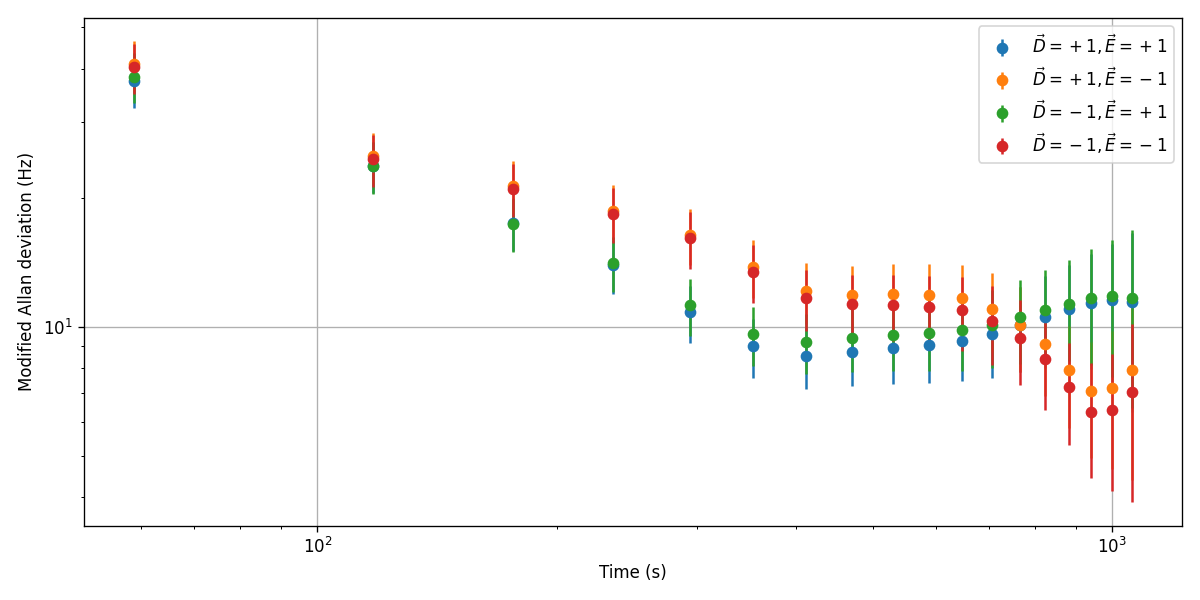

In [268]:
fig, ax = plt.subplots(figsize = (10, 5), dpi = 120)

for kk, D_mask in enumerate([D_p1_mask, D_m1_mask]):
    for ll, E_mask in enumerate([E_p1_mask, E_m1_mask]):
        mask = unlock_mask & start_mask & a_mask & D_mask & E_mask
        fs = np.array([result["freq_center"] for result in all_results[mask]])
        taus = np.logspace(0, np.log10(len(fs) // 3), 200)
        real_taus, allan, allan_err, _ = allantools.mdev(fs, data_type="freq", taus=taus)
        real_taus *= all_results[mask][1]["epoch_times"][0] - all_results[mask][0]["epoch_times"][0]
        if kk == 0:
            label = "$\\vec{D} = +1, "
        else:
            label = "$\\vec{D} = -1, "
        if ll == 0:
            label += "\\vec{E} = +1$"
        else:
            label += "\\vec{E} = -1$"
        ax.errorbar(real_taus, allan, allan_err, fmt="o", label=label)
        
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Modified Allan deviation (Hz)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

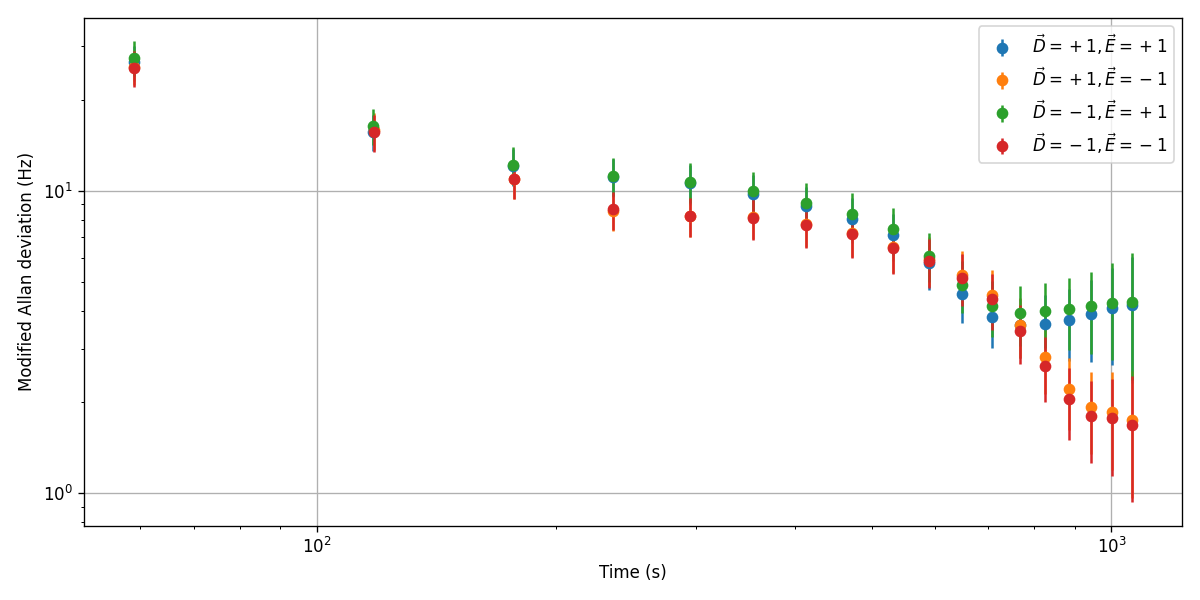

In [269]:
fig, ax = plt.subplots(figsize = (10, 5), dpi = 120)

for kk, D_mask in enumerate([D_p1_mask, D_m1_mask]):
    for ll, E_mask in enumerate([E_p1_mask, E_m1_mask]):
        mask = unlock_mask & start_mask & b_mask & D_mask & E_mask
        fs = np.array([result["freq_center"] for result in all_results[mask]])
        taus = np.logspace(0, np.log10(len(fs) // 3), 200)
        real_taus, allan, allan_err, _ = allantools.mdev(fs, data_type="freq", taus=taus)
        real_taus *= all_results[mask][1]["epoch_times"][0] - all_results[mask][0]["epoch_times"][0]
        if kk == 0:
            label = "$\\vec{D} = +1, "
        else:
            label = "$\\vec{D} = -1, "
        if ll == 0:
            label += "\\vec{E} = +1$"
        else:
            label += "\\vec{E} = -1$"
        ax.errorbar(real_taus, allan, allan_err, fmt="o", label=label)
        
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Modified Allan deviation (Hz)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

In [270]:
mask1 = unlock_mask & start_mask & D_p1_mask
mask2 = unlock_mask & start_mask & D_m1_mask

fs1 = np.array([result["freq_offset"] for result in all_results[mask1]])
fft_freqs1 = np.fft.rfftfreq(len(fs1), all_results[mask1][1]["epoch_times"][0] - all_results[mask1][0]["epoch_times"][0])
fft1 = np.abs(np.fft.rfft(fs1)) / len(fs1)

fs2 = np.array([result["freq_offset"] for result in all_results[mask2]])
fft_freqs2 = np.fft.rfftfreq(len(fs2), all_results[mask2][1]["epoch_times"][0] - all_results[mask2][0]["epoch_times"][0])
fft2 = np.abs(np.fft.rfft(fs2)) / len(fs2)

fs3 = fs2 - fs1
fft_freqs3 = np.fft.rfftfreq(len(fs3), all_results[mask1][1]["epoch_times"][0] - all_results[mask1][0]["epoch_times"][0])
fft3 = np.abs(np.fft.rfft(fs3)) / len(fs3)

fig, ax = plt.subplots(figsize = (10, 5), dpi = 120)
ax.plot(fft_freqs1[1:], fft1[1:], label="$\\vec{D}=+1$")
ax.plot(fft_freqs2[1:], fft2[1:], label="$\\vec{D}=+1$")
ax.plot(fft_freqs3[1:], fft3[1:], label="$\\vec{D}=+1 - \\vec{D}=-1$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Measurement frequency (Hz)")
ax.set_ylabel("Frequency spectrum (Hz)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

KeyError: 'freq_offset'

In [271]:
mask1 = unlock_mask & start_mask & D_p1_mask
mask2 = unlock_mask & start_mask & D_m1_mask
num_of_segments = 16

fs1 = np.array([result["freq_offset"] for result in all_results[mask1]])
t_step1 = all_results[mask1][1]["epoch_times"][0]-all_results[mask1][0]["epoch_times"][0]
welch_freqs1, welch1 = welch(fs1, fs=1/t_step1, nperseg=len(fs1)//num_of_segments, scaling="spectrum")
welch1 = np.sqrt(welch1)

fs2 = np.array([result["freq_offset"] for result in all_results[mask2]])
t_step2 = all_results[mask2][1]["epoch_times"][0]-all_results[mask2][0]["epoch_times"][0]
welch_freqs2, welch2 = welch(fs2, fs=1/t_step2, nperseg=len(fs2)//num_of_segments, scaling="spectrum")
welch2 = np.sqrt(welch2)

fs3 = fs2 - fs1
welch_freqs3, welch3 = welch(fs3, fs=1/t_step1, nperseg=len(fs3)//num_of_segments, scaling="spectrum")
welch3 = np.sqrt(welch3)

fig, ax = plt.subplots(figsize = (10, 5), dpi = 120)
ax.plot(welch_freqs1, welch1, label="$\\vec{D}=+1$")
ax.plot(welch_freqs2, welch2, label="$\\vec{D}=+1$")
ax.plot(welch_freqs3, welch3, label="$\\vec{D}=+1 - \\vec{D}=-1$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Measurement frequency (Hz)")
ax.set_ylabel("Frequency spectrum (Hz)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

KeyError: 'freq_offset'

## Averaged data

In [293]:
def uniform_averaging(average_time, *args):
    """Averages times and frequencies data, and samples them at the same times.
    
    Args can be any number of pairs of times and freqs.
    """
    all_data = {}
    for kk in range(len(args) // 2):
        all_data[f"d{kk}"] = np.array([args[kk * 2], args[kk * 2 + 1]])
    min_time = 0
    max_time = np.inf
    for kk in all_data:
        dataset_min_time = np.min(all_data[kk][0])
        dataset_max_time = np.max(all_data[kk][0])
        if dataset_max_time < max_time:
            max_time = dataset_max_time
        if dataset_min_time > min_time:
            min_time = dataset_min_time
    sample_times = np.arange(min_time + average_time / 2, max_time - average_time / 2, average_time)
    frequencies_sampled = {}
    for kk in all_data:
        frequencies = []
        for sample_time in sample_times:
            mask = (all_data[kk][0] >= sample_time - average_time / 2) & (all_data[kk][0] < sample_time + average_time / 2)
            frequencies.append(np.average(all_data[kk][1][mask]))
        frequencies_sampled[kk] = np.array(frequencies)
    return tuple([sample_times] + list(frequencies_sampled.values()))

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

ValueError: zero-size array to reduction operation minimum which has no identity

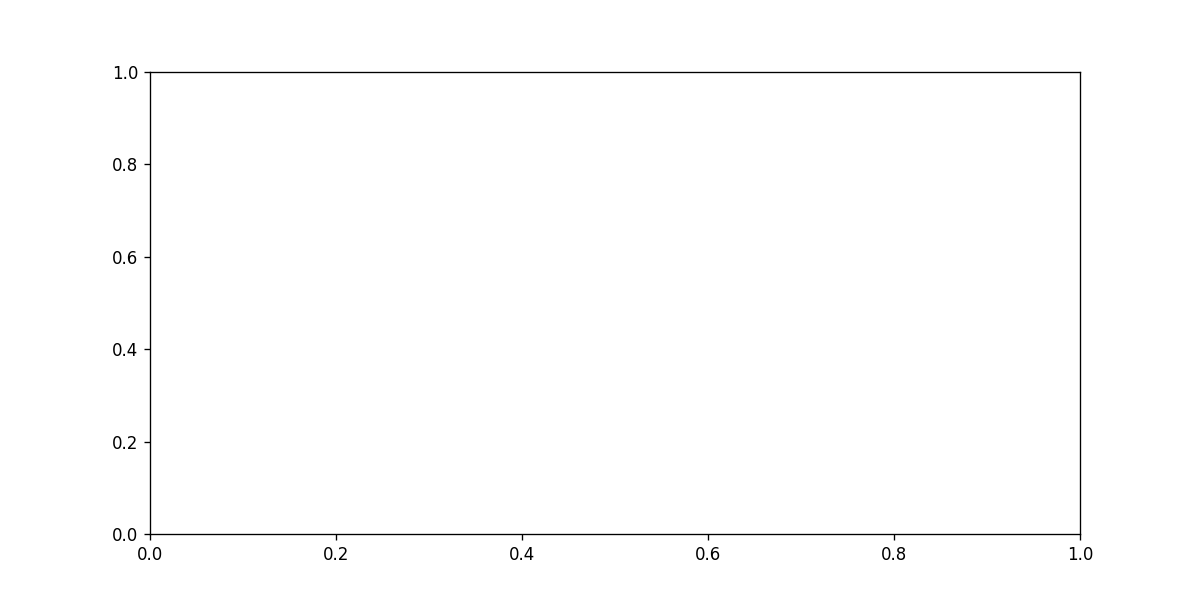

In [294]:
fig, ax = plt.subplots(figsize = (10, 5), dpi = 120)
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6
average_time = 100

data = []
for ll, D_mask in enumerate([D_p1_mask, D_m1_mask]):
    for kk, E_mask in enumerate([E_p1_mask, E_m1_mask]):
        mask = unlock_mask & start_mask & a_mask & D_mask & E_mask
        data.append([result["epoch_times"][0] for result in all_results[mask]])
        data.append([result["freq_center"] for result in all_results[mask]])
sample_times, D_p1_E_p1, D_p1_E_m1, D_m1_E_p1, D_m1_E_m1 = uniform_averaging(average_time, *tuple(data))

for kk, data in enumerate([D_p1_E_p1, D_p1_E_m1, D_m1_E_p1, D_m1_E_m1]):
    if kk < 2:
        label = "$\\vec{D} = +1, "
    else:
        label = "$\\vec{D} = -1, "
    if kk % 2 == 0:
        label += "\\vec{E} = +1$"
    else:
        label += "\\vec{E} = -1$"
    ts = sample_times
    fs = data
    
    ts_plt = [datetime.fromtimestamp(t) for t in ts]
    ax.plot(ts_plt, fs, alpha=bins_alpha, label=label, color=f"C{kk}",)
    
ax.set_xlabel("Toronto time")
ax.set_ylabel("Time-binned $a\\bar{a}$ frequency (Hz)")
ax.legend()
plt.tight_layout()
plt.show()

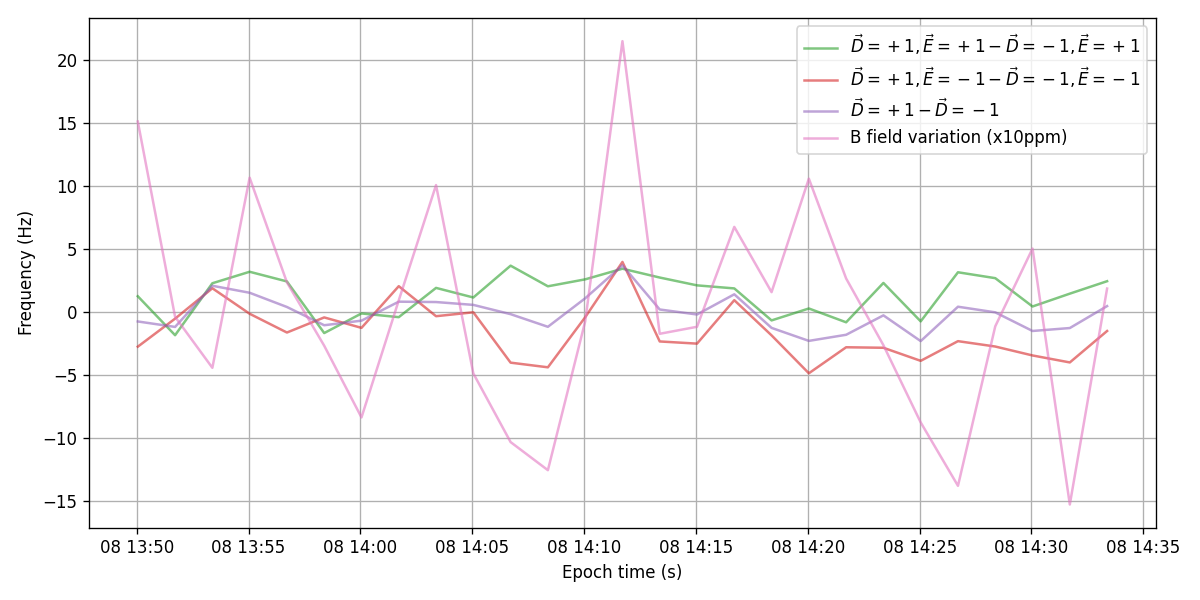

In [274]:
fig, ax = plt.subplots(figsize = (10, 5), dpi = 120)
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

D_p1_E_p1_D_p1_E_m1 = D_p1_E_p1 - D_p1_E_m1
D_m1_E_p1_D_m1_E_m1 = D_m1_E_p1 - D_m1_E_m1

D_p1_E_p1_D_m1_E_p1 = D_p1_E_p1 - D_m1_E_p1
D_p1_E_m1_D_m1_E_m1 = D_p1_E_m1 - D_m1_E_m1

D_p1_D_m1 = ((D_p1_E_p1 + D_p1_E_m1) - (D_m1_E_p1 + D_m1_E_m1)) / 2
E_p1_E_m1 = ((D_p1_E_p1 + D_m1_E_p1) - (D_p1_E_m1 + D_m1_E_m1)) / 2

all = (D_p1_E_p1 + D_p1_E_m1 + D_m1_E_p1 + D_m1_E_m1) / 4
all = ((all / np.average(all)) - 1) * 1e5

for kk, data in enumerate([D_p1_E_p1_D_p1_E_m1, D_m1_E_p1_D_m1_E_m1, D_p1_E_p1_D_m1_E_p1, D_p1_E_m1_D_m1_E_m1, D_p1_D_m1, E_p1_E_m1, all]):
    if kk == 0:
        label = "$\\vec{D} = +1, \\vec{E} = +1 - \\vec{D} = +1, \\vec{E} = -1$"
        continue
    if kk == 1:
        label = "$\\vec{D} = -1, \\vec{E} = +1 - \\vec{D} = -1, \\vec{E} = -1$"
        continue
    if kk == 2:
        label = "$\\vec{D} = +1, \\vec{E} = +1 - \\vec{D} = -1, \\vec{E} = +1$"
    if kk == 3:
        label = "$\\vec{D} = +1, \\vec{E} = -1 - \\vec{D} = -1, \\vec{E} = -1$"
    if kk == 4:
        label = "$\\vec{D} = +1 - \\vec{D} = -1$"
    if kk == 5:
        label = "$\\vec{E} = +1 - \\vec{E} = -1$"
        continue
    if kk == 6:
        label = "B field variation (x10ppm)"
    ts = sample_times
    fs = data
    
    ts_plt = [datetime.fromtimestamp(t) for t in ts]
    ax.plot(ts_plt, fs, alpha=bins_alpha, label=label, color=f"C{kk}")
    
ax.set_xlabel("Epoch time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

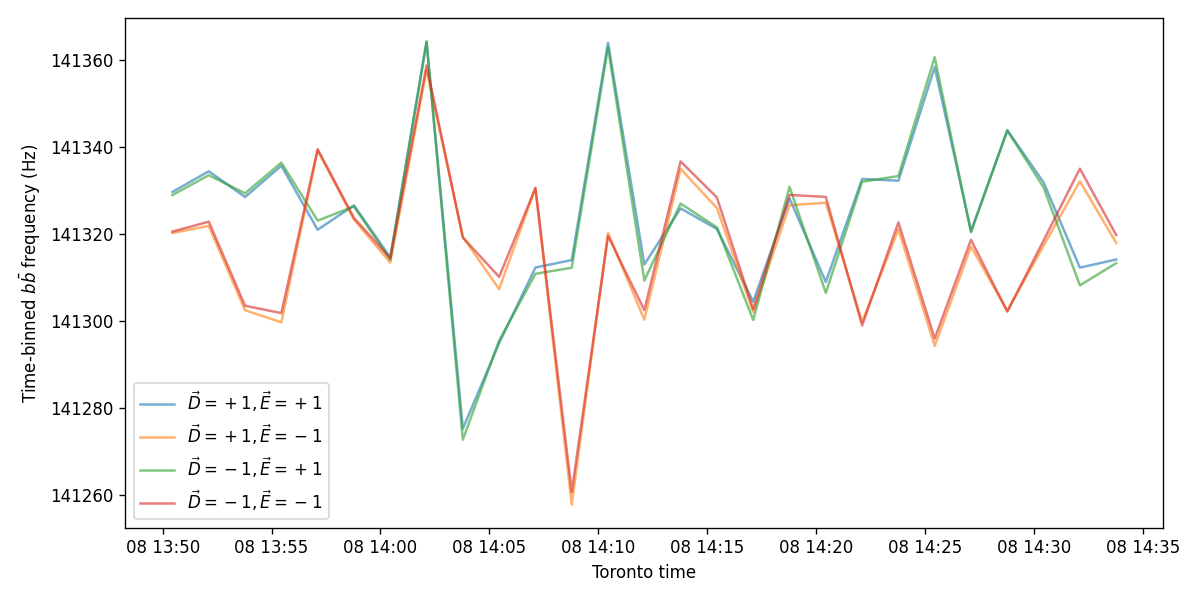

In [275]:
fig, ax = plt.subplots(figsize = (10, 5), dpi = 120)
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

data = []
for ll, D_mask in enumerate([D_p1_mask, D_m1_mask]):
    for kk, E_mask in enumerate([E_p1_mask, E_m1_mask]):
        mask = unlock_mask & start_mask & b_mask & D_mask & E_mask
        data.append([result["epoch_times"][0] for result in all_results[mask]])
        data.append([result["freq_center"] for result in all_results[mask]])
sample_times, D_p1_E_p1, D_p1_E_m1, D_m1_E_p1, D_m1_E_m1 = uniform_averaging(average_time, *tuple(data))

for kk, data in enumerate([D_p1_E_p1, D_p1_E_m1, D_m1_E_p1, D_m1_E_m1]):
    if kk < 2:
        label = "$\\vec{D} = +1, "
    else:
        label = "$\\vec{D} = -1, "
    if kk % 2 == 0:
        label += "\\vec{E} = +1$"
    else:
        label += "\\vec{E} = -1$"
    ts = sample_times
    fs = data
    
    ts_plt = [datetime.fromtimestamp(t) for t in ts]
    ax.plot(ts_plt, fs, alpha=bins_alpha, label=label, color=f"C{kk}",)
    
ax.set_xlabel("Toronto time")
ax.set_ylabel("Time-binned $b\\bar{b}$ frequency (Hz)")
ax.legend()
plt.tight_layout()
plt.show()

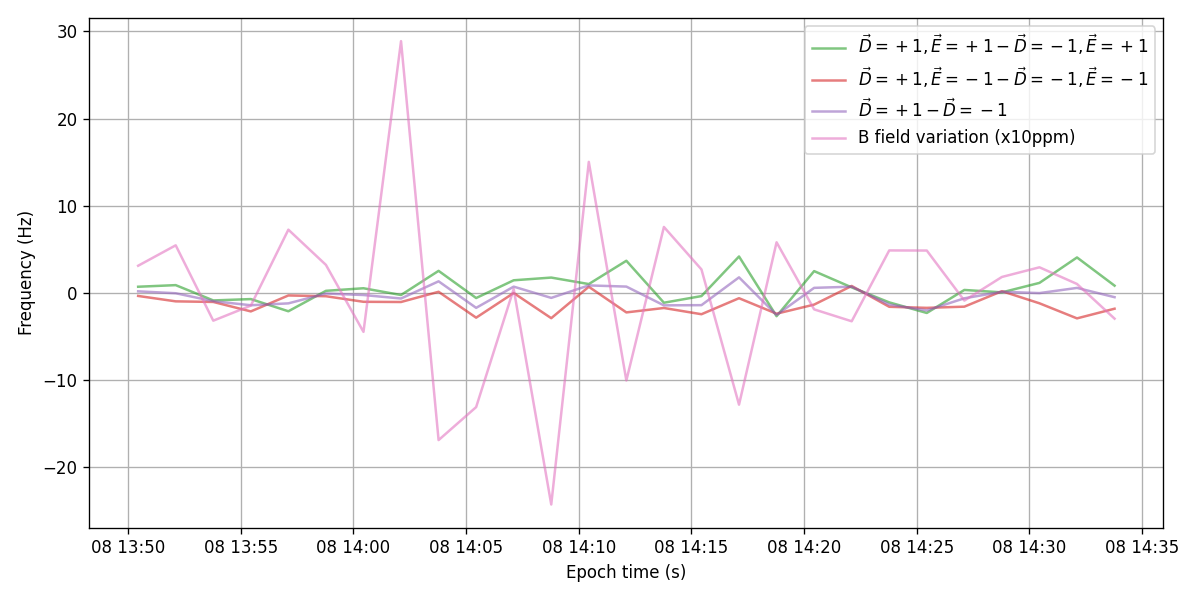

In [276]:
fig, ax = plt.subplots(figsize = (10, 5), dpi = 120)
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

D_p1_E_p1_D_p1_E_m1 = D_p1_E_p1 - D_p1_E_m1
D_m1_E_p1_D_m1_E_m1 = D_m1_E_p1 - D_m1_E_m1

D_p1_E_p1_D_m1_E_p1 = D_p1_E_p1 - D_m1_E_p1
D_p1_E_m1_D_m1_E_m1 = D_p1_E_m1 - D_m1_E_m1

D_p1_D_m1 = ((D_p1_E_p1 + D_p1_E_m1) - (D_m1_E_p1 + D_m1_E_m1)) / 2
E_p1_E_m1 = ((D_p1_E_p1 + D_m1_E_p1) - (D_p1_E_m1 + D_m1_E_m1)) / 2

all = (D_p1_E_p1 + D_p1_E_m1 + D_m1_E_p1 + D_m1_E_m1) / 4
all = ((all / np.average(all)) - 1) * 1e5

for kk, data in enumerate([D_p1_E_p1_D_p1_E_m1, D_m1_E_p1_D_m1_E_m1, D_p1_E_p1_D_m1_E_p1, D_p1_E_m1_D_m1_E_m1, D_p1_D_m1, E_p1_E_m1, all]):
    if kk == 0:
        label = "$\\vec{D} = +1, \\vec{E} = +1 - \\vec{D} = +1, \\vec{E} = -1$"
        continue
    if kk == 1:
        label = "$\\vec{D} = -1, \\vec{E} = +1 - \\vec{D} = -1, \\vec{E} = -1$"
        continue
    if kk == 2:
        label = "$\\vec{D} = +1, \\vec{E} = +1 - \\vec{D} = -1, \\vec{E} = +1$"
    if kk == 3:
        label = "$\\vec{D} = +1, \\vec{E} = -1 - \\vec{D} = -1, \\vec{E} = -1$"
    if kk == 4:
        label = "$\\vec{D} = +1 - \\vec{D} = -1$"
    if kk == 5:
        label = "$\\vec{E} = +1 - \\vec{E} = -1$"
        continue
    if kk == 6:
        label = "B field variation (x10ppm)"
    ts = sample_times
    fs = data
    
    ts_plt = [datetime.fromtimestamp(t) for t in ts]
    ax.plot(ts_plt, fs, alpha=bins_alpha, label=label, color=f"C{kk}")
    
ax.set_xlabel("Epoch time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()